# Financial statement as waterfall chart

In [1]:
import refinitiv.dataplatform.legacy as ek
import pandas as pd
import plotly.graph_objects as go
import warnings
import ipywidgets as widgets
import ipysheet
warnings.filterwarnings('ignore')

ek.set_app_key('DEFAULT_CODE_BOOK_APP_KEY')

df = pd.DataFrame()
name = ''
datatable = None

ric = 'LSEG.L'

fields = ['CF_NAME',
          'TR.F.TotRevBizActiv', 
          'TR.F.ProvImpairForLoanLosses',
          'TR.F.CostOfOpRev', 
          'TR.F.SGATot', 
          'TR.F.OthOpExpnIncNet', 
          'TR.F.OpProfBefNonRecurIncExpn',
          'TR.F.FinIncExpnNetTot',
          'TR.F.SaleOfTangIntangFixedAssetsGL',
          'TR.F.EqEarnLossBefTaxInclNonRecur',
          'TR.F.OthNonOpIncExpnTot',
          'TR.F.NonRecurIncExpnTot',
          'TR.F.IncBefTax',
          'TR.F.IncTax',
          'TR.F.EqInEarnLossOfAffilAfterTax',
          'TR.F.AfterTaxAdjOthTot',
          'TR.F.ExordActivAfterTaxGL',
          'TR.F.MinIntr',
          'TR.F.IntrExpnHybridDebtInstrEq',
          'TR.F.DistribForPrefShr',
          'TR.F.EarnAdjToNetIncOthExpnInc',
          'TR.F.IncAvailToComShr'
         ]

multipliers = [1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1]

measure=['absolute',
         'relative',
         'relative', 
         'relative', 
         'relative', 
         'absolute', 
         'relative', 
         'relative', 
         'relative',
         'relative',
         'relative',
         'absolute',
         'relative',
         'relative',
         'relative',
         'relative',
         'relative',
         'relative',
         'relative',
         'relative',
         'absolute'
        ]

category=['Revenue',
          'Operating Expenses',
          'Operating Expenses',
          'Operating Expenses',
          'Operating Expenses',
          'Operating Profit',
          'Non-operating Expenses',
          'Non-operating Expenses',
          'Non-operating Expenses',
          'Non-operating Expenses',
          'Non-recurring Income/Expense',
          'Pre-tax Income',
          'Taxes',
          'After Tax Income/Expense',
          'After Tax Income/Expense',
          'After Tax Income/Expense',
          'After Tax Income/Expense',
          'Net Income',
          'Net Income',
          'Net Income',
          'Net Income'
         ]

def get_data(ric, fields):
    global df, name
    if ric != '':
        _df, err = ek.get_data(ric, fields)
        name = _df['CF_NAME'][0]
        _df = _df.drop(columns='Instrument')
        _df = _df.drop(columns='CF_NAME')
        df2 = pd.DataFrame(multipliers, columns=[1]).T
        df3 = pd.DataFrame(measure, columns=[2]).T
        df2.columns=_df.columns
        df3.columns=_df.columns
        _df = _df.append([df2, df3])
        _df = _df.dropna(axis=1)
        df = _df
    return

def update_plot(fig):
    fig.data = []
    trace = go.Waterfall(
        x=df.columns.tolist(),
        y=df.iloc[0]*df.iloc[1].tolist(),
        measure=df.iloc[2],
        increasing=dict(marker=dict(color='#3AC46D')),
        decreasing=dict(marker=dict(color='#F6465C')),
        totals=dict(marker=dict(color='#6978F7')),
        name=name
    )
    fig.update_layout(title=dict(text=name))
    fig.add_trace(trace)
    return

def update_table():
    global sheet, tab
    _df_to_table = pd.DataFrame()
    _df_to_table['Item'] = df.columns.tolist()
    _df_to_table['Latest'] = df.iloc[0].values.tolist()
    table = ipysheet.from_dataframe(_df_to_table)
    table.row_headers=False
    sheet = table
    tab.children = [wfig, sheet]
    return

def update_ric(value):
    global ric_input, ric
    value = value['new']
    if value != '':
        ric = value
        get_data(ric, fields)
        update_plot(wfig)
        update_table()
        ric_input.value = ''
    return

wfig = go.FigureWidget()

get_data(ric, fields)

trace = go.Waterfall(
    x=df.columns.tolist(),
    y=df.iloc[0]*df.iloc[1].tolist(),
    measure=df.iloc[2],
    increasing=dict(marker=dict(color='#3AC46D')),
    decreasing=dict(marker=dict(color='#F6465C')),
    totals=dict(marker=dict(color='#6978F7')),
    name = name
)

wfig.update_layout(
    margin=dict(t=5, b=5, l=5, r=5),
    plot_bgcolor='#1A1A1D',
    paper_bgcolor='#1A1A1D',
    yaxis=dict(gridcolor='black', gridwidth=1, zerolinecolor='black', zerolinewidth=1, side='right', color='#D6D6D5', linecolor='#D6D6D5', ticks='outside'),
    xaxis=dict(gridcolor='black', gridwidth=1, zerolinecolor='black', zerolinewidth=1, color='#D6D6D5', linecolor='#D6D6D5', ticks='outside'),
    colorway=['#6978F7', '#A325E9', '#96E05D', '#4A7FB9', '#E75A2D', '#FBE55A', '#8C8C8D', '#5A54F6'],
    legend=dict(font=dict(color='#D6D6D5'), orientation='h', yanchor='top', xanchor='center', y=1.05, x=0.1),
    title = dict(text=name, xanchor='center', yanchor='top', x=0.5, font=dict(color='#D6D6D5'))
)

wfig.add_trace(trace)

_df_to_table = pd.DataFrame()
_df_to_table['Item'] = df.columns.tolist()
_df_to_table['Latest'] = df.iloc[0].values.tolist()
sheet = ipysheet.from_dataframe(_df_to_table)
sheet.row_headers=False

tab = widgets.Tab()
tab.children = [wfig, sheet]
tab.set_title(0, 'Chart')
tab.set_title(1, 'Table')

ric_input = widgets.Text(description='RIC', continuous_update=False, style={'description_width':'30px'})
ric_input.observe(update_ric, names='value')
widgets.VBox([ric_input, tab])

# Analyst consensus 

In [13]:
import refinitiv.dataplatform.eikon as ek
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import Box
import matplotlib as plt
import warnings
%matplotlib inline
plt.style.use("seaborn")
warnings.filterwarnings("ignore")
ek.set_app_key('DEFAULT_CODE_BOOK_APP_KEY') 

In [17]:
ric = widgets.Text(
    value='',
    placeholder='Type something',
    description='RIC:',
    disabled=False
)

items = [ric]
box = Box(children=items)

box

Box(children=(Text(value='', description='RIC:', placeholder='Type something'),))

In [20]:
df,err = ek.get_data(ric.value,["TR.HeadquartersCountry","TR.ExchangeName","TR.TRBCIndustryGroup","TR.GICSSector","TR.TickerSymbol"])
df.transpose()

,0
Instrument,LSEG.L
Country of Headquarters,United Kingdom
Exchange Name,LONDON STOCK EXCHANGE
TRBC Industry Group Name,Investment Banking & Investment Services
GICS Sector Name,Financials
Ticker Symbol,LSEG


In [21]:
df1,err = ek.get_data(ric.value,["CF_CURR","TR.PriceClose","TR.Price52WeekHigh","TR.Price52WeekLow","TR.PriceTargetMedian","TR.InterimFrequency"])
df1.transpose()

,0
Instrument,LSEG.L
CF_CURR,GBp
Price Close,8456
Price 52 Week High,8612
Price 52 Week Low,6710
Price Target - Median,9800
Interim Frequency,Semi-Annual


In [22]:
df2,err = ek.get_data(ric.value,["TR.DividendYield","TR.PriceClose(sdate=FY0)","TR.EPSActvalue(Period=FY0)",
                                "TR.PtoEPSMeanEst(Period=FY1)","TR.SharesOutstanding(Scale=6)","TR.CompanyMarketCap",
                                "TR.CompanyMarketCap().currency"])
if df2['Currency'][0] == df1['CF_CURR'][0]:
    df2['PE FY0'] = df2['Price Close']/df2['Earnings Per Share - Actual']
else: 
    df2['PE FY0'] = (df2['Price Close']/100)/df2['Earnings Per Share - Actual']
    
df2.transpose()

,0
Instrument,LSEG.L
Dividend yield,1.250877
Price Close,7136
Earnings Per Share - Actual,3.161
Price / EPS (Mean Estimate),24.531008
Outstanding Shares,552.44859
Company Market Cap,46715052770.400002
Currency,GBP
PE FY0,22.575134


In [23]:
df3,err = ek.get_data(ric.value,['TR.EPSActValue(period=FY0)','TR.EPSMeanEstimate(period=FY1)',
                                 'TR.EPSMeanEstimate(period=FY2)','TR.EPSMeanEstimate(period=FY3)',
                                 'TR.RevenueActValue(Period=FY0)','TR.RevenueMeanEstimate(Period=FY1)',
                                 'TR.RevenueMeanEstimate(Period=FY2)','TR.RevenueMeanEstimate(Period=FY3)',
                                ])
df3.columns =['RIC','EPS-FY0','EPS-FY1','EPS-FY2','EPS-FY3','SALES-FY0','SALES-FY1','SALES-FY2','SALES-FY3']
df3['EPS-FY1/FY0'] = (df3['EPS-FY1']/df3['EPS-FY0']-1)*100
df3['EPS-FY2/FY1'] = (df3['EPS-FY2']/df3['EPS-FY1']-1)*100
df3['EPS-FY3/FY2'] = (df3['EPS-FY3']/df3['EPS-FY2']-1)*100
df3['SALES-FY1/FY0'] = (df3['SALES-FY1']/df3['SALES-FY0']-1)*100
df3['SALES-FY2/FY1'] = (df3['SALES-FY2']/df3['SALES-FY1']-1)*100
df3['SALES-FY3/FY2'] = (df3['SALES-FY3']/df3['SALES-FY2']-1)*100

df3.iloc[:,9:].transpose()

,0
EPS-FY1/FY0,8.596137
EPS-FY2/FY1,12.315179
EPS-FY3/FY2,12.525625
SALES-FY1/FY0,7.977952
SALES-FY2/FY1,6.172693
SALES-FY3/FY2,6.364642


<AxesSubplot:>

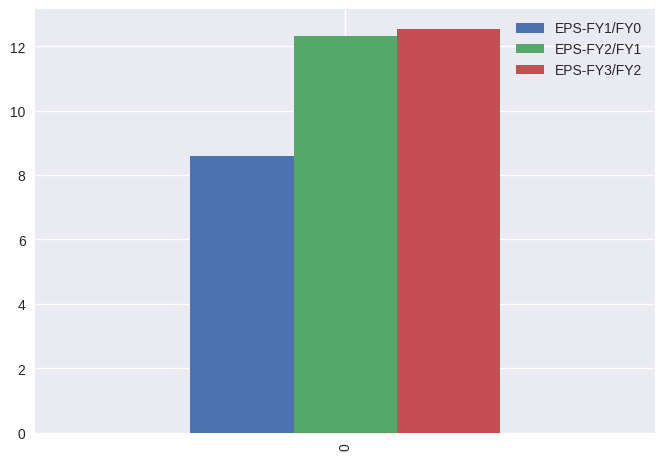

In [24]:
df3.iloc[:,9:12].plot(kind='bar')

<AxesSubplot:>

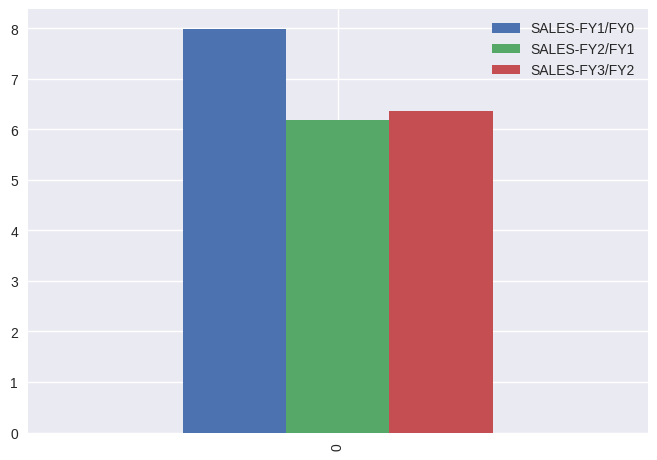

In [25]:
df3.iloc[:,12:16].plot(kind='bar')

In [26]:
df5,err = ek.get_data(ric.value,['TR.PtoEPSMeanEst(SDate=0,EDate=2,Period=FY1,Frq=FY).rfperiod','TR.PtoEPSMeanEst(SDate=0,EDate=2,Period=FY1,Frq=FY)','TR.PtoREVMeanEst(SDate=0,EDate=2,Period=FY1,Frq=FY)'])
df5

,Instrument,Financial Period Relative,Price / EPS (Mean Estimate),Price / Revenue (Mean Estimate)
0,LSEG.L,FY1,20.10339,4.932961
1,LSEG.L,FY2,21.841222,5.485763
2,LSEG.L,FY3,19.409998,5.157506


In [27]:
mSel = widgets.Dropdown(
    options=['BVPS', 'CFPS', 'DPS','EPS','EBIT','EBITDA','NETDEBT','NETPROFIT','PRETAXPROFIT','ROA','ROE','REVENUE'], #just a sellection you can add any more you want here
    value='BVPS',
    description='Metric:',
    disabled=False,
)

items2 = [mSel]
box2 = Box(children=items2)
box2

Box(children=(Dropdown(description='Metric:', options=('BVPS', 'CFPS', 'DPS', 'EPS', 'EBIT', 'EBITDA', 'NETDEB…

In [28]:
try:
    df5,err = ek.get_data(ric.value,['TR.'+mSel.value+'Mean(SDate=0,EDate=2,Period=FY1,Frq=FY).fperiod','TR.'+mSel.value+'Mean(SDate=0,EDate=2,Period=FY1,Frq=FY)','TR.'+mSel.value+'High(SDate=0,EDate=2,Period=FY1,Frq=FY)','TR.'+mSel.value+'Low(SDate=0,EDate=2,Period=FY1,Frq=FY)','TR.'+mSel.value+'Median(SDate=0,EDate=2,Period=FY1,Frq=FY)'])
    display(df5)
except:
    print('Metric not available for this company, please select another metric')

,Instrument,Financial Period Absolute,Book Value Per Share - Mean,Book Value Per Share - High,Book Value Per Share - Low,Book Value Per Share - Median
0,LSEG.L,FY2023,44.994924,53.1,12.7421,47.91215
1,LSEG.L,FY2024,46.866299,55.2,12.948,51.51
2,LSEG.L,FY2025,48.943318,57.7,13.5237,52.18


In [29]:
if df1['Interim Frequency'][0] == 'Quarterly':
    try:
        df6,err = ek.get_data(ric.value,['TR.'+mSel.value+'Mean(SDate=0,EDate=2,Period=FQ1,Frq=FQ).fperiod','TR.'+mSel.value+'Mean(SDate=0,EDate=2,Period=FQ1,Frq=FQ)','TR.'+mSel.value+'High(SDate=0,EDate=2,Period=FQ1,Frq=FQ)','TR.'+mSel.value+'Low(SDate=0,EDate=2,Period=FQ1,Frq=FQ)','TR.'+mSel.value+'Median(SDate=0,EDate=2,Period=FQ1,Frq=FQ)'])
        display(df6)
    except:
        print('Metric not available for this company, please select another metric')
else:
    try:
        df6,err = ek.get_data(ric.value,['TR.'+mSel.value+'Mean(SDate=0,EDate=2,Period=FI1,Frq=FI).fperiod','TR.'+mSel.value+'Mean(SDate=0,EDate=2,Period=FI1,Frq=FI)','TR.'+mSel.value+'High(SDate=0,EDate=2,Period=FI1,Frq=FI)','TR.'+mSel.value+'Low(SDate=0,EDate=2,Period=FI1,Frq=FI)','TR.'+mSel.value+'Median(SDate=0,EDate=2,Period=FI1,Frq=FI)'])
        display(df6)
    except:
        print('Metric not available for this company, please select another metric')

,Instrument,Financial Period Absolute,Book Value Per Share - Mean,Book Value Per Share - High,Book Value Per Share - Low,Book Value Per Share - Median
0,LSEG.L,<NA>,<NA>,<NA>,<NA>,<NA>
